# TP13
Criar um Oráculo que encontre o estado |001> numa lista de 8 elementos.

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *

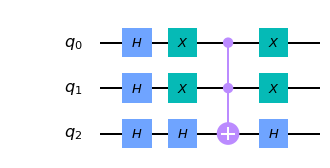

In [2]:
qc = QuantumCircuit(3)

#inicialização
qc.h(0)
qc.h(1)
qc.h(2)

#oráculo que altera a fase
qc.x(0)
qc.x(1)

qc.h(2)
qc.ccx(0,1,2)
qc.h(2)

qc.x(0)
qc.x(1)


qc.draw(output='mpl')

In [3]:
backend_state = Aer.get_backend('statevector_simulator') # the device to run on

result = execute(qc, backend_state).result()
psi2  = result.get_statevector(qc)

In [4]:
psi2.real

array([ 0.35355339,  0.35355339,  0.35355339,  0.35355339, -0.35355339,
        0.35355339,  0.35355339,  0.35355339])

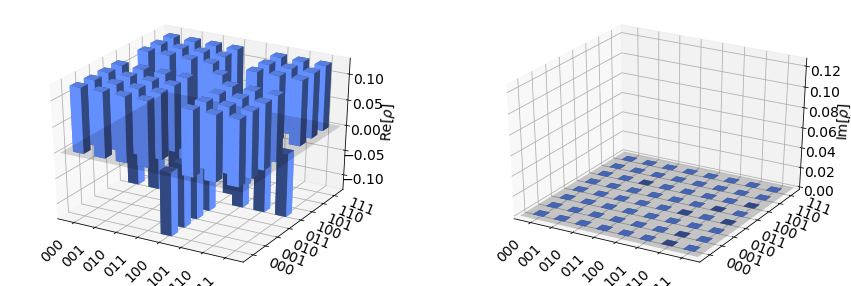

In [5]:
plot_state_city(psi2)

In [6]:
#nº de bits
x=3

In [7]:
def ccZ(circuit):
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.h(2)
    circuit.barrier()

def select_w(circuit, qr):
    circuit.x(qr[0])
    circuit.x(qr[1])
    circuit.barrier()

def phase_oracle(circuit, qr):
    select_w(circuit,qr)
    ccZ(circuit)
    select_w(circuit,qr)
    circuit.barrier()


### Oracle $U_w$

In [8]:
def diffuser(circuit, qr_x):
    circuit.h(qr_x)
    circuit.x(qr_x)
    ccZ(circuit)
    circuit.x(qr_x)
    circuit.h(qr_x)

In [9]:
import math as m

times= round((m.pi/4)*m.sqrt(2**(x)))
print(times)

2


In [10]:
backend = Aer.get_backend("qasm_simulator")

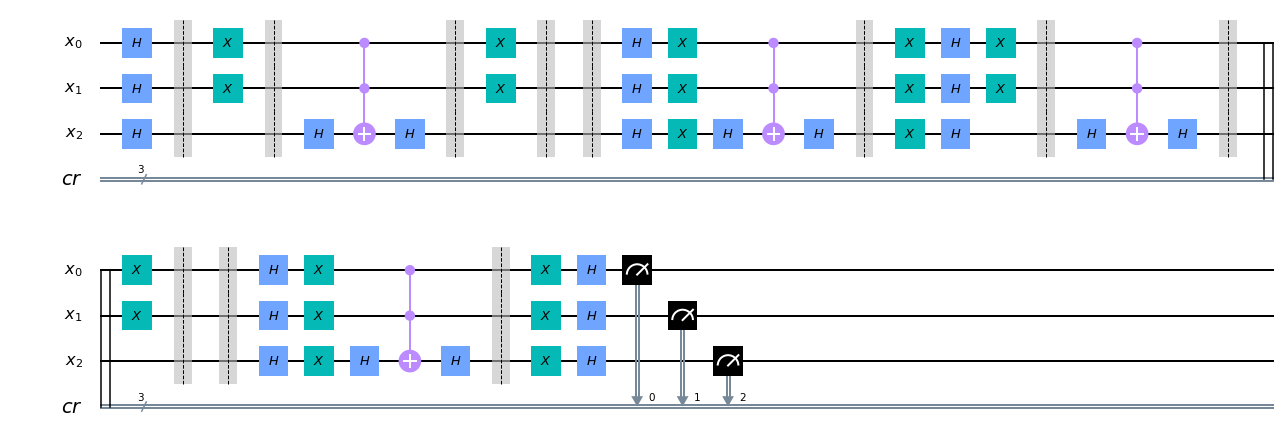

In [18]:
cr=ClassicalRegister(x,'cr')
qr = QuantumRegister(x, 'x')

qc_Grover= QuantumCircuit(qr,cr)

# 1.init
qc_Grover.h(qr)

qc_Grover.barrier()

# 2.oracle and diffuser 

for t in range(times):
    # a)
    phase_oracle(qc_Grover, qr)
    # b)
    diffuser(qc_Grover,qr)

# 3.     
qc_Grover.measure(qr,cr)

qc_Grover.draw(output='mpl')

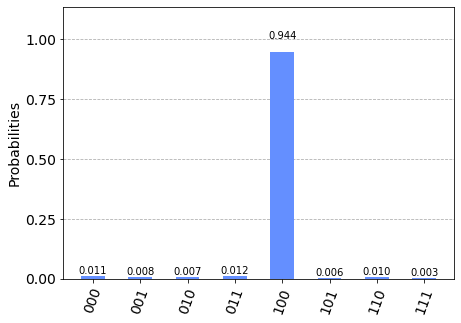

In [20]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)